In [1]:
import pandas as pd
df = pd.read_csv('data.txt', encoding='windows-1251')

In [2]:
user_columns = ['DR_Dat', 'DR_Tim', 'DR_NChk', 'DR_NDoc', 
                'DR_Apt', 'DR_NDrugs', 'DR_Kol', 'DR_CZak', 'DR_CRoz', 
                'DR_SDisc', 'DR_TPay', 'DR_CDrugs',  
                'DR_Suppl','DR_CDisc', 'DR_BCDisc', 'DR_TabEmpl',
                'DR_VZak', 'DR_Pos']

df = df[user_columns]

In [3]:
df.columns = ['date', 'time', 'n_chk', 'n_doc', 'apt', 'name_drugs',
       'amnt', 'purch_price', 'retail_price', 'disc', 'pay_type', 'drug_id',
       'supplier', 'disc_id', 'disc_barcode', 'employee', 'vzak', 'pos']

In [4]:
df['disc_barcode'] = df['disc_barcode'].astype('str').replace(r'\.0', '', regex=True)
df['date']= pd.to_datetime(df['date']).dt.strftime('%d.%m.%Y')
df['vzak'] = df['vzak'].astype('str').replace('1', 'offline').replace('2', 'online')
df = df.fillna(0)

In [5]:
df.head(10)

,date,time,n_chk,n_doc,apt,name_drugs,amnt,purch_price,retail_price,disc,pay_type,drug_id,supplier,disc_id,disc_barcode,employee,vzak,pos
0,11.08.2022,10:15:35,2173,2004598,2,ЦИПРОЛЕТ 3МГ/МЛ. 5МЛ. №1 ГЛ.КАПЛИ ФЛ./КАП. /Д-...,1.0,41.08,51.0,12.0,18,45399,Катрен г.Химки,925.0,200000000492,205,offline,1.0
1,11.08.2022,10:27:46,2174,2004598,2,ПЕРЕКИСЬ ВОДОРОДА 3% 100МЛ. №40 Р-Р ФЛ.,1.0,18.61,31.0,3.0,15,261519,Катрен г.Химки,9.0,200010010204,205,offline,1.0
2,11.08.2022,10:27:46,2174,2004598,2,СОФЬЯ ГЕЛЬ Д/НОГ ВЕНОТОНИЗ. ТРОКСЕРУТИН ФОРТЕ ...,1.0,132.69,209.0,20.0,15,460864,Катрен г.Химки,9.0,200010010204,205,offline,2.0
3,11.08.2022,10:27:46,2174,2004598,2,СОФЬЯ ГХК КРЕМ Д/ТЕЛА ХОНДРОИТИН+ГЛЮКОЗАМИН 12...,1.0,133.65,210.0,21.0,15,172823,Катрен г.Химки,9.0,200010010204,205,offline,3.0
4,11.08.2022,10:33:56,2175,2004598,2,ГАЛВУС 50МГ. №28 ТАБ. /НОВАРТИС/,1.0,709.95,787.0,49.0,18,79056,Катрен г.Химки,925.0,200000000492,205,offline,1.0
5,11.08.2022,10:40:38,2176,2004598,2,БИСОПРОЛОЛ 5МГ. №60 ТАБ. П/П/О /ВЕРТЕКС/,1.0,152.90,182.0,9.0,18,187304,Пульс,9.0,200010001947,205,offline,1.0
6,11.08.2022,10:40:38,2176,2004598,2,ТРИХОПОЛ 250МГ. №20 ТАБ. /ПОЛЬФАРМА/,1.0,67.94,85.0,4.0,18,1261,ГРАНД КАПИТАЛ СМОЛЕНСК ООО ФК,9.0,200010001947,205,offline,2.0
7,11.08.2022,10:52:52,2177,2004598,2,НОРВАСК 5МГ. №30 ТАБ. /ПФАЙЗЕР/АПДЖОН/,1.0,157.76,189.0,9.0,18,2566,Катрен г.Химки,9.0,200010013331,205,offline,3.0
8,11.08.2022,10:52:52,2177,2004598,2,НОРВАСК 5МГ. №30 ТАБ. /ПФАЙЗЕР/АПДЖОН/,1.0,159.40,191.0,9.0,18,2566,Катрен г.Химки,9.0,200010013331,205,offline,4.0
9,11.08.2022,10:52:52,2177,2004598,2,СОТАГЕКСАЛ 80МГ. №20 ТАБ. /ГЕКСАЛ АГ/,1.0,71.97,90.0,4.0,18,5155,Катрен г.Химки,9.0,200010013331,205,offline,5.0


In [6]:
# this function shows structure of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4462 entries, 0 to 4461
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          4462 non-null   object 
 1   time          4462 non-null   object 
 2   n_chk         4462 non-null   int64  
 3   n_doc         4462 non-null   int64  
 4   apt           4462 non-null   int64  
 5   name_drugs    4462 non-null   object 
 6   amnt          4462 non-null   float64
 7   purch_price   4462 non-null   float64
 8   retail_price  4462 non-null   float64
 9   disc          4462 non-null   float64
 10  pay_type      4462 non-null   int64  
 11  drug_id       4462 non-null   int64  
 12  supplier      4462 non-null   object 
 13  disc_id       4462 non-null   float64
 14  disc_barcode  4462 non-null   object 
 15  employee      4462 non-null   int64  
 16  vzak          4462 non-null   object 
 17  pos           4462 non-null   float64
dtypes: float64(6), int64(6), obj

In [7]:
# i can use describe method to get most of the descriptive parameters of the dataframe
df.describe()
# this method only shows non-objective type columns - only int and float type columns will be shown

,n_chk,n_doc,apt,amnt,purch_price,retail_price,disc,pay_type,drug_id,disc_id,employee,pos
count,4462.000000,4.462000e+03,4462.000000,4462.000000,4462.000000,4462.000000,4462.000000,4462.000000,4.462000e+03,4462.000000,4462.000000,4462.000000
mean,4903.135365,1.084300e+07,10.838861,1.027755,241.639034,306.049148,10.561094,16.896011,2.592271e+05,61.930524,91.737786,2.681085
std,1839.700082,6.107181e+06,6.107773,0.538485,454.557985,532.173394,31.368047,1.446943,2.990739e+05,219.631064,108.081697,2.748813
min,1698.000000,2.004595e+06,2.000000,0.007220,0.010000,0.010000,0.000000,15.000000,3.000000e+00,0.000000,25.000000,1.000000
25%,4187.000000,6.003620e+06,6.000000,1.000000,36.645000,52.000000,0.000000,15.000000,2.906000e+04,0.000000,37.000000,1.000000
50%,4877.500000,1.100704e+07,11.000000,1.000000,103.785000,137.000000,0.000000,18.000000,1.873040e+05,0.000000,53.000000,2.000000
75%,5472.750000,1.800254e+07,18.000000,1.000000,299.060000,391.750000,7.000000,18.000000,3.775890e+05,9.000000,123.000000,3.000000
max,8490.000000,1.800254e+07,18.000000,20.000000,11851.130000,12345.000000,650.000000,18.000000,1.504498e+06,941.000000,605.000000,24.000000


In [8]:
# to work with categorical data i need to use construction like this
df['pay_type'].value_counts()

pay_type
18    2820
15    1642
Name: count, dtype: int64

In [9]:
# i also can call column by .
df.pay_type.value_counts()

pay_type
18    2820
15    1642
Name: count, dtype: int64

In [10]:
df.apt.value_counts().sort_values()

apt
7      153
15     177
17     243
13     322
6      511
11     870
2      979
18    1207
Name: count, dtype: int64

In [11]:
# % from all
df.apt.value_counts(normalize=True)

apt
18    0.270506
2     0.219408
11    0.194980
6     0.114523
13    0.072165
17    0.054460
15    0.039668
7     0.034290
Name: proportion, dtype: float64

<Axes: >

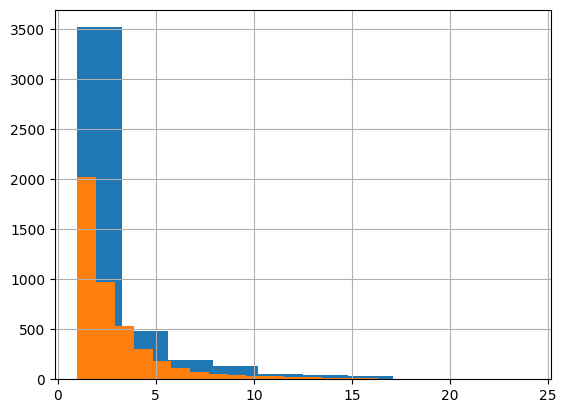

In [12]:
# using a histogram to estimate a distribution
df.pos.value_counts() # this does almost what i need, but its not fancy
df.pos.hist() # will build histogram
df.pos.hist(bins=24) # i can set custom bins

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# pandas couldnt convert it to float, stated that this is str
df['time'] = pd.to_datetime(df['time']).dt.strftime('%H:%M:%S')

/var/folders/m2/02db1vqj4dn9n70qsljztby00000gn/T/ipykernel_94851/3763016483.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time']).dt.strftime('%H:%M:%S')


In [15]:
# pandas couldnt convert it to float, stated that this is str. I clearly changed type
df['name_drugs'] = df.name_drugs.astype('str')

In [16]:
# pandas couldnt convert it to float, stated that this is str. I clearly changed type, but it didnt help
df['supplier'] = df.supplier.astype('str').replace('\"', '', regex=True).replace(' ', '_', regex=True)

In [17]:
# checking what it sees as number columns
df.select_dtypes(include='number').columns 

Index(['n_chk', 'n_doc', 'apt', 'amnt', 'purch_price', 'retail_price', 'disc',
       'pay_type', 'drug_id', 'disc_id', 'employee', 'pos'],
      dtype='object')

<Axes: >

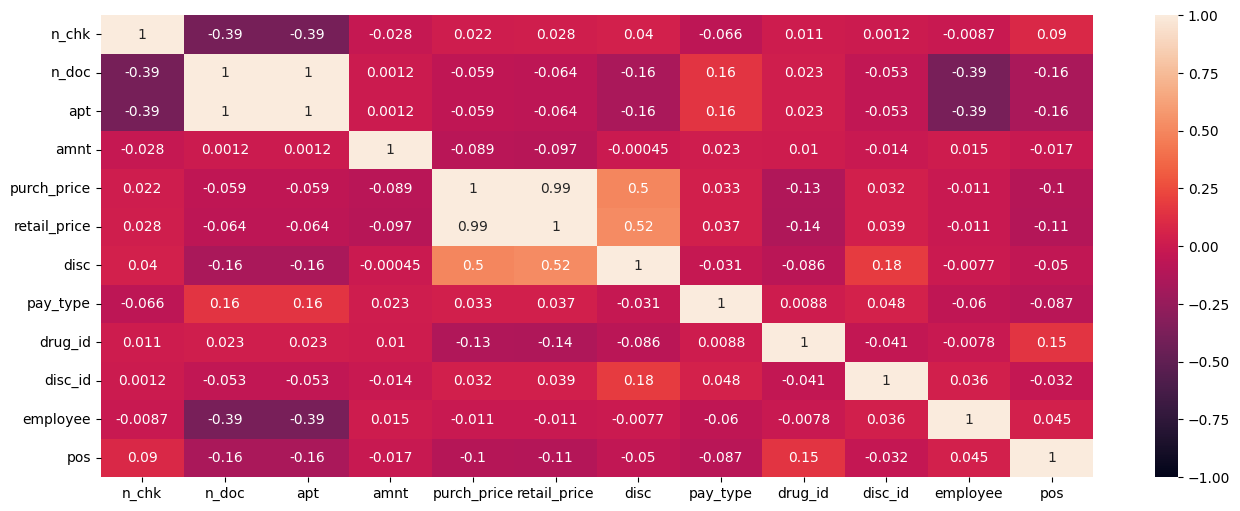

In [18]:
# one of ways to find correlation is to build heatmap
# i need to give correlation matrix of my dataframe
plt.figure(figsize=(16, 6)) # this way i can customize the look of heatmap
sns.heatmap(df.corr(numeric_only=True), vmax=1, vmin=-1, annot=True) # specified that it should use only numeric columns
# also added vmax and vmin to clearly see positive and negative correlation

In [19]:
# i created new column so i can evaluate the distribution of sold items by hour
df['hour'] = pd.to_datetime(df.time).dt.hour

/var/folders/m2/02db1vqj4dn9n70qsljztby00000gn/T/ipykernel_94851/3847301434.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hour'] = pd.to_datetime(df.time).dt.hour


In [20]:
# in my data file i need to count column 'amnt' by each hour and see distribution
ds = df.groupby(['hour'])['amnt'].agg('sum')
# logic is similar to sql -- im summing column 'amnt' and grouping it by column 'hour'
# im assigning it to a new variable since i need to male boxplot

<Axes: ylabel='amnt'>

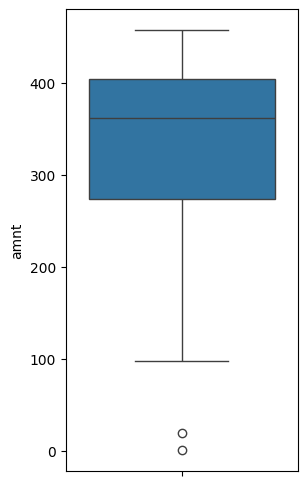

In [21]:
plt.figure(figsize=(3, 6))
sns.boxplot(ds)

In [22]:
# here is more complex example of grouping
# i can set rules of agg in dictionary - column name would be a key and value is what i need to do (count, sum, max, etc)
a = df.groupby(['date', 'n_chk'])[['amnt', 'retail_price', 'purch_price']].agg({
    'amnt': 'sum', 
    'retail_price': ['sum', 'max'],
    'purch_price': 'sum'
})

In [23]:
a.head()
# here the grouping column became index, not a separate columns

amnt retail_price        purch_price
                  sum          sum    max         sum
date       n_chk                                     
11.08.2022 1698   1.0        463.0  463.0      342.30
           1699   1.0        720.0  720.0      545.27
           1700   1.0         60.0   60.0       36.68
           1701   4.0        955.0  443.0      756.12
           1702   1.0         94.0   94.0       76.55

In [24]:
# with this function i can make them separate columns
a.reset_index()

date n_chk  amnt retail_price        purch_price
                         sum          sum    max         sum
0     11.08.2022  1698   1.0        463.0  463.0      342.30
1     11.08.2022  1699   1.0        720.0  720.0      545.27
2     11.08.2022  1700   1.0         60.0   60.0       36.68
3     11.08.2022  1701   4.0        955.0  443.0      756.12
4     11.08.2022  1702   1.0         94.0   94.0       76.55
...          ...   ...   ...          ...    ...         ...
1936  12.08.2022  8486   1.0        460.0  460.0      302.07
1937  12.08.2022  8487   1.0        476.0  476.0      396.66
1938  12.08.2022  8488   1.0        220.0  220.0      187.84
1939  12.08.2022  8489  18.0       1089.0  180.0      778.61
1940  12.08.2022  8490   3.0        869.0  775.0      626.13

[1941 rows x 6 columns]

In [25]:
# here is an example of counting revenue for every day by every employee
# agg functin cant accept math operations inside, so one way around is to make a new column
rev_1 = df.groupby(['date', 'employee'])[['retail_price', 'purch_price']].agg('sum')
rev_1['revenue'] = rev_1['retail_price'] - rev_1['purch_price']
rev_1['revenue'] = rev_1['revenue'].round(2) # here i rounded values in revenue column
rev_1 = rev_1.reset_index() # here i reassigned rev datarfame


In [26]:
# here i sorted it by revenue in descending order (ascending by default)
rev_1.sort_values(by='revenue', ascending=False)

,date,employee,retail_price,purch_price,revenue
7,11.08.2022,123,116678.03,88926.21,27751.82
10,12.08.2022,37,118091.37,92688.93,25402.44
14,12.08.2022,123,124231.66,99298.80,24932.86
13,12.08.2022,110,113275.05,89126.47,24148.58
1,11.08.2022,30,111916.97,90350.41,21566.56
0,11.08.2022,25,93030.00,72004.24,21025.76
11,12.08.2022,48,93032.02,72773.60,20258.42
4,11.08.2022,50,90830.01,72304.41,18525.60
3,11.08.2022,47,86626.01,68458.33,18167.68
12,12.08.2022,54,83229.05,65852.52,17376.53


In [ ]:
# second way is using 'apply' function after grouping
# it will apply everything i out in it to all columns - in this case its 'retail_price' and 'purch_price'
rev_2 = df.groupby(['date', 'employee'])[['retail_price', 'purch_price', 'amnt']].apply(lambda x: sum(x['amnt'] * (x['retail_price'] - x['purch_price'])))
# in this case x in lambda is a row in a column
rev_2 = rev_2.reset_index()
# this way is better becouse it is easier to add new variables such as amnt in this example

In [28]:
# changed names for columns
rev_2.columns = ['date', 'employee', 'revenue']
rev_2['revenue'] = rev_2['revenue'].round(2)

In [29]:
# sorted by date and revenue in descending order
rev_2.sort_values(['date','revenue'], ascending=False)

,date,employee,revenue
14,12.08.2022,123,23167.41
13,12.08.2022,110,22711.32
10,12.08.2022,37,22613.80
11,12.08.2022,48,19244.82
12,12.08.2022,54,16801.83
15,12.08.2022,205,8873.30
7,11.08.2022,123,23756.34
0,11.08.2022,25,20642.29
1,11.08.2022,30,20328.67
4,11.08.2022,50,17384.41


In [30]:
# this is how i can round by hundreds
df['r_retail_price'] = df.retail_price.apply(lambda x: round(x, -2))

In [31]:
diag = df.groupby(['date', 'r_retail_price'])['amnt'].agg('sum').reset_index()

<Axes: xlabel='r_retail_price', ylabel='amnt'>

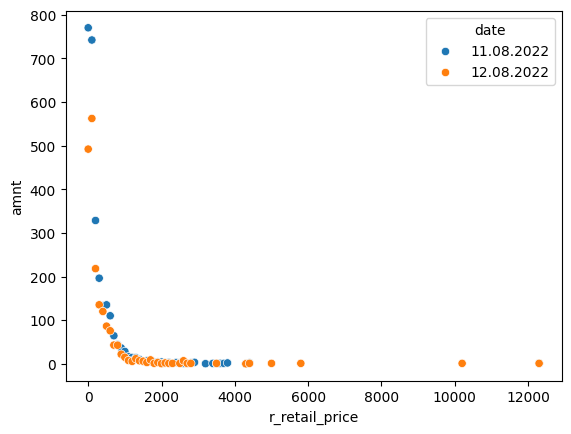

In [32]:
# to make scatterplot i can use seaborn
sns.scatterplot(data=diag, x='r_retail_price', y='amnt', hue='date')

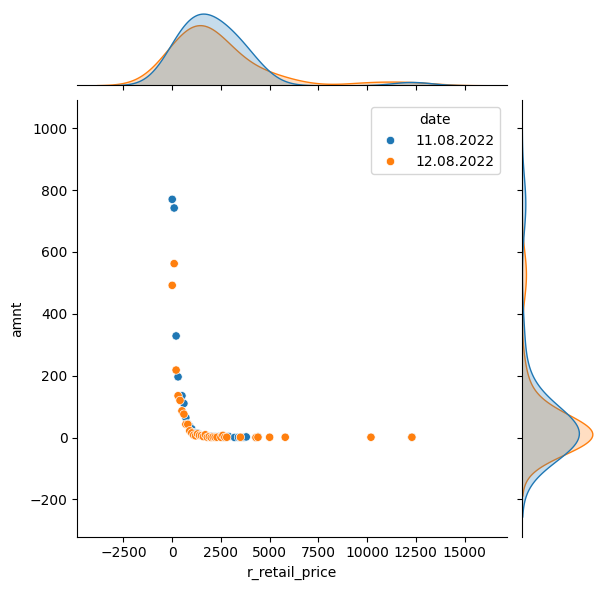

In [33]:
sns.jointplot(data=diag, x='r_retail_price', y='amnt', hue='date')

In [34]:
# to make this data to look more clean and readable i can make pivot tables 
df.groupby(['date', 'apt', 'employee', 'pay_type'])[['amnt']].agg('sum')

amnt
date       apt employee pay_type            
11.08.2022 2   123      15        151.052226
                        18        164.134440
               205      15         65.107143
                        18         66.000000
           6   25       15         95.000000
                        18        142.534286
           7   605      15         67.040000
                        18        101.850000
           11  30       15        179.000000
                        18        310.480000
           13  50       15        180.400000
                        18        151.783333
           15  53       15         51.980000
                        18        142.100000
           17  36       15         54.733333
                        18        186.945000
           18  47       15         89.040000
                        18        236.237143
               54       15         65.100000
                        18        198.765714
12.08.2022 2   123      15        210.495714
                        18        152.715714
               205      15         88.414566
                        18         80.185434
           6   37       15         72.924218
                        18        207.887687
           11  110      15         91.670833
                        18        363.075714
           18  48       15        134.792857
                        18        222.651429
               54       15         64.100000
                        18        197.645714

In [35]:
pt = df.groupby(['date', 'apt', 'employee', 'pay_type'])[['amnt']].agg('sum').reset_index()

In [37]:
pt.pivot_table(values='amnt', index=['date', 'apt', 'employee'], columns='pay_type')

pay_type                         15          18
date       apt employee                        
11.08.2022 2   123       151.052226  164.134440
               205        65.107143   66.000000
           6   25         95.000000  142.534286
           7   605        67.040000  101.850000
           11  30        179.000000  310.480000
           13  50        180.400000  151.783333
           15  53         51.980000  142.100000
           17  36         54.733333  186.945000
           18  47         89.040000  236.237143
               54         65.100000  198.765714
12.08.2022 2   123       210.495714  152.715714
               205        88.414566   80.185434
           6   37         72.924218  207.887687
           11  110        91.670833  363.075714
           18  48        134.792857  222.651429
               54         64.100000  197.645714

In [38]:
# i can also do pivot table from initial dataframe, without groupby and agg steps
df.pivot_table(values='amnt', index=['date', 'apt', 'employee'], columns='pay_type', aggfunc='sum')
# i just need to add one extra argument 'aggfunc' - it will tel what type of agg i need for values

pay_type                         15          18
date       apt employee                        
11.08.2022 2   123       151.052226  164.134440
               205        65.107143   66.000000
           6   25         95.000000  142.534286
           7   605        67.040000  101.850000
           11  30        179.000000  310.480000
           13  50        180.400000  151.783333
           15  53         51.980000  142.100000
           17  36         54.733333  186.945000
           18  47         89.040000  236.237143
               54         65.100000  198.765714
12.08.2022 2   123       210.495714  152.715714
               205        88.414566   80.185434
           6   37         72.924218  207.887687
           11  110        91.670833  363.075714
           18  48        134.792857  222.651429
               54         64.100000  197.645714

In [41]:
# i also can unpivot tables
pvt = df.pivot_table(values='amnt', index=['date', 'apt', 'employee'], columns='pay_type', aggfunc='sum').reset_index()

In [ ]:
#id_vars is the same as index above, what stays unchanged
# value_vars is what i need to unpivot - change from columns to one column 'pay_type'
pd.melt(pvt, id_vars=['date', 'apt', 'employee'], value_vars=[15, 18], var_name='changed_back_pay_type')
# last argument is for changing name for a new column

,date,apt,employee,changed_back_pay_type,value
0,11.08.2022,2,123,15,151.052226
1,11.08.2022,2,205,15,65.107143
2,11.08.2022,6,25,15,95.000000
3,11.08.2022,7,605,15,67.040000
4,11.08.2022,11,30,15,179.000000
5,11.08.2022,13,50,15,180.400000
6,11.08.2022,15,53,15,51.980000
7,11.08.2022,17,36,15,54.733333
8,11.08.2022,18,47,15,89.040000
9,11.08.2022,18,54,15,65.100000


In [ ]:
# both these functions - pivot_table and melt are often used in tasks like changing long table to wide and vice versa

In [55]:
# if i need to find something specific like 'positions which sold more then 5 times' or 'where price is higher then ...' i can use this
# like in sql 'where something something'
df.iloc[5,5] # this command will return 5th row in 5th column
df.iloc[:5, 5] # this will return all rows till 5th (not including it) in 5th column
df.iloc[:5, :5] # all rows and columns before 5
df.iloc[1:5, 2:4] # this will give from 1 to 5 rows in 2 to 4 columns (not including last one)

,n_chk,n_doc
1,2174,2004598
2,2174,2004598
3,2174,2004598
4,2175,2004598


In [ ]:
# iloc only works with indexes, if i want to search by column names i can use loc
df.loc[2:5, ['date', 'apt']] # i need rows from 2 to 5 in columns 'date' and 'apt'

,date,apt
2,11.08.2022,2
3,11.08.2022,2
4,11.08.2022,2
5,11.08.2022,2


In [ ]:
# so to look by some specific parameter line 'where something something' i can use this
df['amnt'] > 5 # this will return massive with True\False, so i need to index that
df[df['amnt']>5] # this will return all rows where value in column 'amnt' is more then 5

,date,time,n_chk,n_doc,apt,name_drugs,amnt,purch_price,retail_price,disc,pay_type,drug_id,supplier,disc_id,disc_barcode,employee,vzak,pos,hour,r_retail_price
202,11.08.2022,14:03:40,4206,7002453,7,АСКОРБИНОВАЯ К-ТА 25МГ. №10 ТАБ. КРУТКА САХ. /...,7.0,4.98,9.0,0.0,18,564894,Катрен_г.Химки,0.0,nan,605,offline,1.0,14,0.0
698,11.08.2022,18:40:22,1773,15002523,15,"НАФТИЗИН 0,1% 15МЛ. НАЗАЛ.КАПЛИ ФЛ./КАП. /ЛЕККО/",6.0,16.05,22.0,0.0,18,496504,Катрен_г.Химки,0.0,nan,53,offline,2.0,18,0.0
699,11.08.2022,19:44:25,1787,15002523,15,"НАФТИЗИН 0,1% 15МЛ. НАЗАЛ.КАПЛИ ФЛ./КАП. /ЛЕККО/",10.0,16.05,22.0,0.0,18,496504,Катрен_г.Химки,0.0,nan,53,offline,1.0,19,0.0
834,11.08.2022,10:36:28,8277,2004595,2,"СФМ СИСТЕМА Д/ПЕРЕЛ. Р-РОВ ИГЛА G21 0,8Х40ММ №...",10.0,25.61,42.0,0.0,18,419205,Арал_плюс,0.0,nan,123,offline,6.0,10,0.0
1151,11.08.2022,13:10:36,5115,6003620,6,СФМ СИСТЕМА Д/ПЕРЕЛИВ. ИНФУЗ. Р-РОВ №1 ПЛАСТ.И...,10.0,29.80,52.0,62.0,15,422260,Пульс,35.0,200000000022,25,offline,9.0,13,100.0
2256,11.08.2022,11:27:32,4672,11007004,11,"НАФТИЗИН 0,1% 15МЛ. НАЗАЛ.КАПЛИ ФЛ./КАП. /СЛАВ...",20.0,5.74,8.0,0.0,18,348186,Норман,0.0,nan,30,offline,1.0,11,0.0
2495,11.08.2022,18:13:44,4778,11007004,11,"ЛЕЙКОПЛАСТЫРЬ БАКТЕР. 2,5Х7,2 №1 /ВЕРОФАРМ/",8.0,1.98,4.0,0.0,18,33001,ВИТТА_КОМПАНИ_ООО,0.0,nan,30,offline,2.0,18,0.0
2497,11.08.2022,19:36:44,4805,11007004,11,"ЛЕЙКОПЛАСТЫРЬ БАКТЕР. 2,5Х7,2 №1 /ВЕРОФАРМ/",8.0,1.98,4.0,0.0,18,33001,ВИТТА_КОМПАНИ_ООО,0.0,nan,30,offline,1.0,19,0.0
2595,12.08.2022,10:26:56,2236,2004623,2,ЛЕЙКОПЛАСТЫРЬ БАКТЕР. 6X10 №1 /ВЕРОФАРМ/,9.0,6.19,11.0,9.0,15,81988,ГРАНД_КАПИТАЛ_СМОЛЕНСК_ООО_ФК,9.0,200010021585,205,offline,2.0,10,0.0
3468,12.08.2022,19:24:24,5007,11007039,11,"ЛЕЙКОПЛАСТЫРЬ БАКТЕР. 2,5Х7,2 №1 /ВЕРОФАРМ/",8.0,1.98,4.0,0.0,18,33001,ВИТТА_КОМПАНИ_ООО,0.0,nan,110,offline,2.0,19,0.0


In [62]:
# i can use 'and - &' or 'or - |' 
# every conditions must be in ()
df[(df['amnt'] > 5) | (df['retail_price'] > 2000)]
df[(df['amnt'] > 5) & (df['retail_price'] > 30)]

,date,time,n_chk,n_doc,apt,name_drugs,amnt,purch_price,retail_price,disc,pay_type,drug_id,supplier,disc_id,disc_barcode,employee,vzak,pos,hour,r_retail_price
834,11.08.2022,10:36:28,8277,2004595,2,"СФМ СИСТЕМА Д/ПЕРЕЛ. Р-РОВ ИГЛА G21 0,8Х40ММ №...",10.0,25.61,42.0,0.0,18,419205,Арал_плюс,0.0,nan,123,offline,6.0,10,0.0
1151,11.08.2022,13:10:36,5115,6003620,6,СФМ СИСТЕМА Д/ПЕРЕЛИВ. ИНФУЗ. Р-РОВ №1 ПЛАСТ.И...,10.0,29.80,52.0,62.0,15,422260,Пульс,35.0,200000000022,25,offline,9.0,13,100.0


In [67]:
# if i want to see only rows where 'pay_type' is not 15 and not 20
df[df.loc[: , 'pay_type'].isin([15, 20])] # this function check if values in column are in massive and returns bool df

,date,time,n_chk,n_doc,apt,name_drugs,amnt,purch_price,retail_price,disc,pay_type,drug_id,supplier,disc_id,disc_barcode,employee,vzak,pos,hour,r_retail_price
1,11.08.2022,10:27:46,2174,2004598,2,ПЕРЕКИСЬ ВОДОРОДА 3% 100МЛ. №40 Р-Р ФЛ.,1.0,18.61,31.0,3.0,15,261519,Катрен_г.Химки,9.0,200010010204,205,offline,1.0,10,0.0
2,11.08.2022,10:27:46,2174,2004598,2,СОФЬЯ ГЕЛЬ Д/НОГ ВЕНОТОНИЗ. ТРОКСЕРУТИН ФОРТЕ ...,1.0,132.69,209.0,20.0,15,460864,Катрен_г.Химки,9.0,200010010204,205,offline,2.0,10,200.0
3,11.08.2022,10:27:46,2174,2004598,2,СОФЬЯ ГХК КРЕМ Д/ТЕЛА ХОНДРОИТИН+ГЛЮКОЗАМИН 12...,1.0,133.65,210.0,21.0,15,172823,Катрен_г.Химки,9.0,200010010204,205,offline,3.0,10,200.0
18,11.08.2022,11:23:22,2180,2004598,2,ЦИТРАМОН П №20 ТАБ. /ФАРМСТАНДАРТ/,1.0,43.31,66.0,4.0,15,393314,Катрен_г.Химки,9.0,200010020147,205,offline,1.0,11,100.0
19,11.08.2022,11:23:22,2180,2004598,2,ЦИТРАМОН П №20 ТАБ. /ФАРМСТАНДАРТ/,1.0,42.08,64.0,4.0,15,393314,ООО_Акцентмед,9.0,200010020147,205,offline,2.0,11,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,12.08.2022,21:31:20,5684,18002542,18,ИХТИОЛОВАЯ 20% 25Г. МАЗЬ Д/НАРУЖ.ПРИМ. ТУБА /У...,2.0,37.48,59.0,0.0,15,565799,Протек,0.0,nan,48,offline,1.0,21,100.0
4453,12.08.2022,21:36:07,5687,18002542,18,"СНУП 0,1% 90МКГ/ДОЗА 15МЛ. НАЗАЛ.СПРЕЙ ФЛ. /ШТ...",1.0,102.45,120.0,6.0,15,72392,Пульс,9.0,200010027575,48,offline,1.0,21,100.0
4454,12.08.2022,21:38:35,5688,18002542,18,МАКСИКОЛД РИНО АПЕЛЬСИН 15Г. №10 ПОР. Д/Р-РА Д...,1.0,221.60,295.0,20.0,15,126129,ГРАНД_КАПИТАЛ_СМОЛЕНСК_ООО_ФК,9.0,200010027575,48,offline,1.0,21,300.0
4455,12.08.2022,21:38:35,5688,18002542,18,ЭДАС-306 ПАССАМБРА НЕВРОЗЫ 100МЛ. СИРОП ФЛ.,1.0,160.73,221.0,22.0,15,5852,Катрен_г.Химки,9.0,200010027575,48,offline,2.0,21,200.0


In [66]:
df[~df.loc[: , 'pay_type'].isin([15, 20])] #by adding ~ in front of the condition i can reverse it

,date,time,n_chk,n_doc,apt,name_drugs,amnt,purch_price,retail_price,disc,pay_type,drug_id,supplier,disc_id,disc_barcode,employee,vzak,pos,hour,r_retail_price
0,11.08.2022,10:15:35,2173,2004598,2,ЦИПРОЛЕТ 3МГ/МЛ. 5МЛ. №1 ГЛ.КАПЛИ ФЛ./КАП. /Д-...,1.0,41.08,51.0,12.0,18,45399,Катрен_г.Химки,925.0,200000000492,205,offline,1.0,10,100.0
4,11.08.2022,10:33:56,2175,2004598,2,ГАЛВУС 50МГ. №28 ТАБ. /НОВАРТИС/,1.0,709.95,787.0,49.0,18,79056,Катрен_г.Химки,925.0,200000000492,205,offline,1.0,10,800.0
5,11.08.2022,10:40:38,2176,2004598,2,БИСОПРОЛОЛ 5МГ. №60 ТАБ. П/П/О /ВЕРТЕКС/,1.0,152.90,182.0,9.0,18,187304,Пульс,9.0,200010001947,205,offline,1.0,10,200.0
6,11.08.2022,10:40:38,2176,2004598,2,ТРИХОПОЛ 250МГ. №20 ТАБ. /ПОЛЬФАРМА/,1.0,67.94,85.0,4.0,18,1261,ГРАНД_КАПИТАЛ_СМОЛЕНСК_ООО_ФК,9.0,200010001947,205,offline,2.0,10,100.0
7,11.08.2022,10:52:52,2177,2004598,2,НОРВАСК 5МГ. №30 ТАБ. /ПФАЙЗЕР/АПДЖОН/,1.0,157.76,189.0,9.0,18,2566,Катрен_г.Химки,9.0,200010013331,205,offline,3.0,10,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4456,12.08.2022,21:39:23,5689,18002542,18,АЛЬБАДЕНТ ОСВЕЖИТЕЛЬ Д/РТА ЛИМОН 35МЛ. СПРЕЙ,1.0,62.34,97.0,0.0,18,28488,Здравсервис,0.0,nan,48,offline,1.0,21,100.0
4457,12.08.2022,21:40:17,5690,18002542,18,КЕТОРОЛ ЭКСПРЕСС 10МГ. №20 ТАБ. ДИСПЕРГ. /Д-Р ...,1.0,47.88,75.0,0.0,18,463100,ГРАНД_КАПИТАЛ_СМОЛЕНСК_ООО_ФК,0.0,nan,48,offline,1.0,21,100.0
4458,12.08.2022,21:40:59,5691,18002542,18,АНТИПОЛИЦАЙ ВАЙТ №6 ТАБ.,1.0,59.51,93.0,0.0,18,112158,Протек,0.0,nan,48,offline,1.0,21,100.0
4459,12.08.2022,21:43:48,5692,18002542,18,СИЛДЕНАФИЛ-СЗ 50МГ. №10 ТАБ. П/П/О /СЕВЕРНАЯ З...,1.0,297.74,396.0,0.0,18,260990,Авеста,0.0,nan,48,offline,1.0,21,400.0


In [76]:
# so this filtering is a good practice with building scatterplot
diag = df.groupby(['date', 'r_retail_price'])['amnt'].agg('sum').reset_index()
diag = diag[diag.r_retail_price < 4000]

<Axes: xlabel='r_retail_price', ylabel='amnt'>

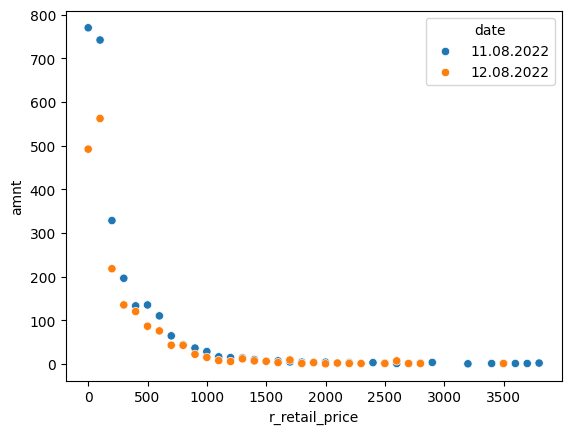

In [ ]:
sns.scatterplot(data=diag, x='r_retail_price', y='amnt', hue='date' )
# i discarded spikes from scatterplot and looks much better now